In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

from sklearn import svm
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest

In [2]:
X_svd = np.loadtxt('../dataset/X_svd.txt', delimiter=',')
X_svd_3 = np.loadtxt('../dataset/X_svd_3.txt', delimiter=',')

## K-Nearest Neighbours

Let us now fit a KNN based model to our data

In [3]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='auto').fit(X_svd_3)
distances, indices = nbrs.kneighbors(X_svd_3)
for i in xrange(2):
    print indices[i]
    print distances[i]
    

[ 0  2 20 22 14 53 26 69 10 16 18 52 31  4  6  8 30 12 28 35]
[  0.00000000e+00   1.37293532e-13   1.37316909e-13   1.37316909e-13
   1.37316909e-13   1.37316909e-13   1.37316909e-13   1.37316909e-13
   1.37316909e-13   1.37316909e-13   1.37316909e-13   1.37316909e-13
   1.37316909e-13   1.37316909e-13   1.37316909e-13   1.37316909e-13
   1.37316909e-13   1.37316909e-13   1.37316909e-13   1.37316909e-13]
[   1   11   15  673  672  659    3  553   29  629  567  355  237  707  666
  336  772  955  679 1114]
[ 0.          0.01121044  0.01252946  0.01943735  0.01967131  0.01990902
  0.01990902  0.02058686  0.02103894  0.02103894  0.02209946  0.02409693
  0.02646973  0.03044256  0.03300916  0.03300916  0.03349929  0.03608496
  0.03608496  0.03722143]


In [4]:
meanDistances = np.mean(distances, axis=1)[:]
print meanDistances[0]
print np.mean(distances[0])
mean = np.mean(meanDistances)
print mean

1.30449894536e-13
1.30449894536e-13
0.0160759210715


In [5]:
def selectMinimumDistanceClusters (indices, distances, threshold):
    finalClusters = []
    normalObservations = []
    anomalies = []
    checked = np.zeros(shape=(len(X_svd_3)))
    for i in xrange(len(meanDistances)):
        if meanDistances[i] >= threshold:
            continue
        else:
            finalClusters.append(i)
            for neighbour in indices[i]:
                if not checked[neighbour]:
                    checked[neighbour] = 1
                    normalObservations.append([neighbour, i])
                else:
                    continue
   
    for point in xrange(len(checked)):
        if not checked[point]:
            anomalies.append(point)
    
    print len(normalObservations), "points clustered"
    print len(anomalies), "anomalies found"
    
    return finalClusters, normalObservations, anomalies

threshold = mean/2
finalClusters, normalObservations, anomalies = selectMinimumDistanceClusters(indices, distances, threshold)
i = 2
while (len(anomalies) >= len(normalObservations)/33):
    if i > 49:
        break
    print "\nRefining the threshold for filtering anomalies"
    threshold = mean/2*i
    finalClusters, normalObservations, anomalies = selectMinimumDistanceClusters(indices, distances, threshold)
    i += 1
print len(finalClusters), "clusters formed"


31259 points clustered
18741 anomalies found

Refining the threshold for filtering anomalies
36476 points clustered
13524 anomalies found

Refining the threshold for filtering anomalies
38777 points clustered
11223 anomalies found

Refining the threshold for filtering anomalies
40261 points clustered
9739 anomalies found

Refining the threshold for filtering anomalies
43975 points clustered
6025 anomalies found

Refining the threshold for filtering anomalies
45828 points clustered
4172 anomalies found

Refining the threshold for filtering anomalies
46973 points clustered
3027 anomalies found

Refining the threshold for filtering anomalies
47773 points clustered
2227 anomalies found

Refining the threshold for filtering anomalies
48718 points clustered
1282 anomalies found
48185 clusters formed


In [6]:
from operator import itemgetter
print max(normalObservations, key=itemgetter(1))

[49983, 49943]


In [7]:
basemap = plt.cm.get_cmap('hsv', len(X_svd_3))
knnColorMap = np.zeros(shape=(len(X_svd_3), 4))
for item in normalObservations:
    knnColorMap[item[0]] = basemap(item[1])
print len(knnColorMap)

50000


In [8]:
cmap = tuple(map(tuple, knnColorMap))

X_normal = np.zeros(shape=(len(normalObservations), 3))
j = 0
for item in normalObservations:
    temp = []
    for i in xrange(3):
        temp.append(X_svd_3[item[0], i])
    X_normal[j] = temp
    j += 1

X_anomalous = np.zeros(shape=(len(anomalies), 3))
j = 0
for point in anomalies:
    temp = []
    for i in xrange(3):
        #print X_svd_3[point, i]
        temp.append(X_svd_3[point, i])
    X_anomalous[j] = temp
    j += 1
#for i in xrange(5):
#    print X_plot[i, 0], X_plot[i, 1], X_plot[i, 2]
#print X_plot.shape


## OCSVM

In [9]:
X_train, X_test = train_test_split(X_svd_3, test_size=0.33, random_state=42)

for i in xrange(3):
    print X_train[i, 0], X_train[i, 1], X_train[i, 2]

for i in xrange(3):
    print X_test[i, 0], X_test[i, 1], X_test[i, 2]

# fit the model
clf = svm.OneClassSVM(nu=0.03, kernel="rbf", gamma=0.1, cache_size=1000)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
n_error_train = y_pred_train[y_pred_train == -1].size
print len(y_pred_train)
print n_error_train
n_error_test = y_pred_test[y_pred_test == -1].size
print len(y_pred_test)
print n_error_test

X_outliers_ocsvm = np.array(np.zeros(shape=(len(X_test),3)))
for i in xrange(len(y_pred_test)):
    if y_pred_test[i] == -1:
        temp = []
        for j in xrange(3):
            temp.append(X_test[i, j])
        X_outliers_ocsvm[i] = temp

-0.16585196278 0.0480424893474 -0.000188663980978
0.26129931165 0.00543058259059 0.00348280378162
31.5090564971 -0.131524142524 -0.0285729718487
-0.220898530482 3.00149478248 -0.302043977228
0.536583810004 2.63746912268 0.373900393335
33.8020228141 -0.994195495255 0.167978728252
33500
1011
16500
438


## Isolation Forest

In [10]:
# fit the model
clf = IsolationForest(max_samples='auto', random_state=42, contamination=0.03)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

X_outliers_IF = np.array(np.zeros(shape=(len(X_test),3)))
for i in xrange(len(y_pred_test)):
    if y_pred_test[i] == -1:
        temp = []
        for j in xrange(3):
            temp.append(X_test[i, j])
        X_outliers_IF[i] = temp

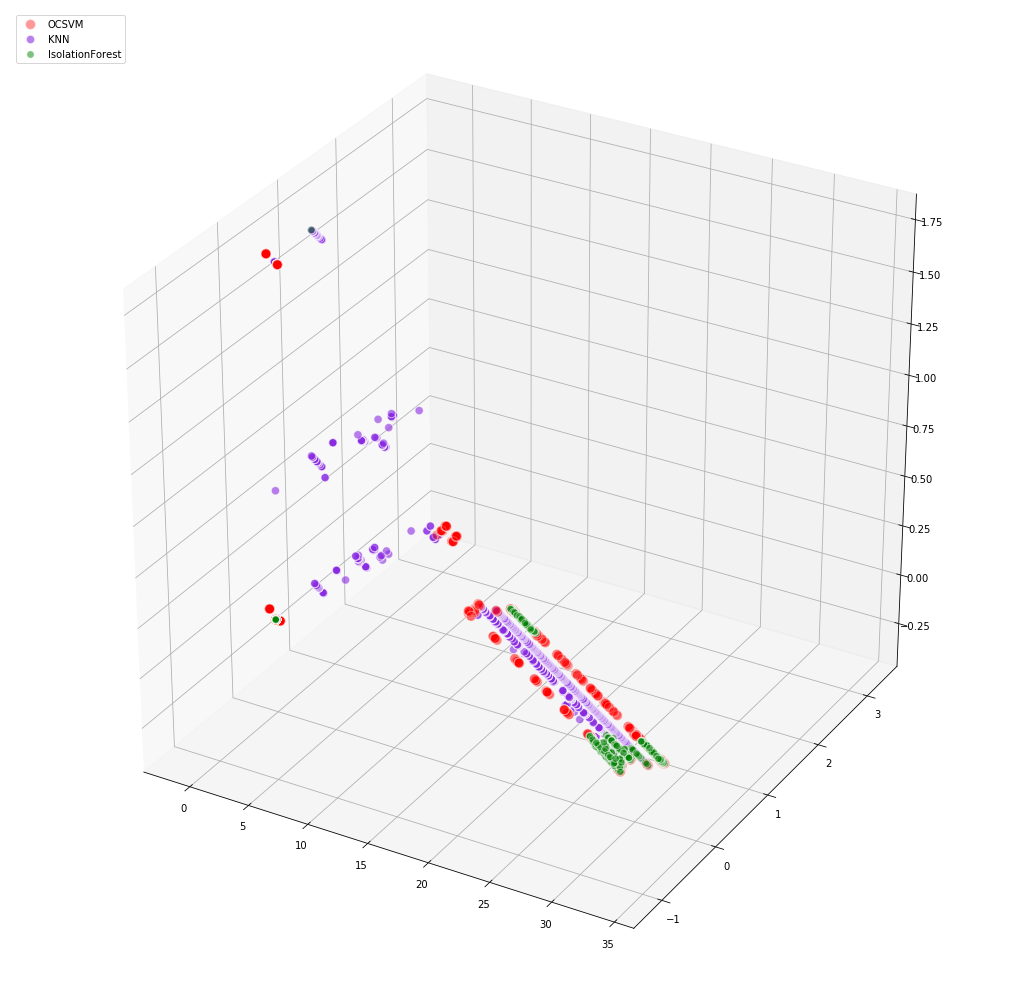

In [11]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X_normal[:,0], X_normal[:,1], X_normal[:,2], s=15, alpha=.3, edgecolor='w', c=cmap)
b3 = ax.scatter(X_outliers_ocsvm[:, 0], X_outliers_ocsvm[:, 1], X_outliers_ocsvm[:, 2], c='red', alpha=0.4, edgecolor='w', s=100)
b4 = ax.scatter(X_anomalous[:,0], X_anomalous[:,1], X_anomalous[:,2], s=70, alpha=0.6, edgecolor='w', c='blueviolet')
c = ax.scatter(X_outliers_IF[:, 0], X_outliers_IF[:, 1], X_outliers_IF[:, 2], alpha=0.5, c='green', edgecolor='w', s=55)

plt.axis('tight')
plt.legend([b3, b4, c],["OCSVM", "KNN", "IsolationForest"], loc="upper left")
plt.show()